# TensorFlow: Image Forecasting

*Lunar Astronomy Forecasting Using a 5D Time Series of Shifting Windows.*

![liberty](../../../images/banner/moons.png)

Although the pipeline runs successfully, this tutorial is considered a 'work in progress' in that the model architecture still needs a bit of work. Here we attempt an self-supervised *walk forward* with an autoencoder whose evaluation data is shifted 2 frames forward. The goal is to show an image to the model and have it infer what that image will look like 2 steps in the future.

---

## Example Data

Reference [Example Datasets](example_datasets.ipynb) for more information.

This dataset is comprised of:

* *Features* = folder of images that represent a time series
* *Target* = we will shift that time series forward 2 frames using a `window`

In [2]:
from aiqc import datum
from aiqc.orm import Dataset

In [3]:
folder_path = 'remote_datum/image/liberty_moon/images'
image_dataset = Dataset.Image.from_folder_pillow(folder_path=folder_path, ingest=False, dtype='float64')

🖼️ Ingesting Images 🖼️: 100%|███████████████████████| 15/15 [00:00<00:00, 117.16it/s]


In [4]:
images_pillow = image_dataset.to_pillow(samples=[0,7,12])

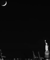

In [5]:
images_pillow[0]

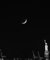

In [6]:
images_pillow[1]

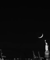

In [7]:
images_pillow[2]

---

## Pipeline

Reference [High-Level API Docs](api_high_level.ipynb) for more information.

In [8]:
from aiqc.mlops import Pipeline, Input, Target, Stratifier
from sklearn.preprocessing import FunctionTransformer
from aiqc.utils.encoding import div255, mult255

In [12]:
pipeline = Pipeline(
    inputs = Input(
        dataset         = image_dataset
        , window          = Input.Window(size_window=1, size_shift=2)
        , encoders        = Input.Encoder(FunctionTransformer(div255, inverse_func=mult255))
        , reshape_indices = (0,3,4)#reshape for Conv1D grayscale.
    ),

    stratifier = Stratifier(size_test=0.25)
)

---

## Modeling

Reference [High-Level API Docs](api_high_level.ipynb) for more information.

In [19]:
from aiqc.mlops import Experiment, Architecture, Trainer
import tensorflow as tf
from tensorflow.keras import layers as l

In [14]:
def fn_build(features_shape, label_shape, **hp):
    m = tf.keras.models.Sequential()
    m.add(l.Conv1D(64*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(l.MaxPool1D( 2, padding='same'))
    m.add(l.Conv1D(32*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(l.MaxPool1D( 2, padding='same'))
    m.add(l.Conv1D(16*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(l.MaxPool1D( 2, padding='same'))

    # decoding architecture
    m.add(l.Conv1D(16*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(l.UpSampling1D(2))
    m.add(l.Conv1D(32*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(l.UpSampling1D(2))
    m.add(l.Conv1D(64*hp['multiplier'], 3, activation=hp['activation']))
    m.add(l.UpSampling1D(2))
    m.add(l.Conv1D(50, 3, activation='relu', padding='same'))# removing sigmoid
    return m

In [15]:
def fn_train(
    model, loser, optimizer,
    train_features, train_label,
    eval_features, eval_label,
    **hp
):
    model.compile(
        optimizer = optimizer
        , loss    = loser
        , metrics = ['mean_squared_error']
    )

    model.fit(
        train_features, train_label
        , validation_data = (eval_features, eval_label)
        , verbose         = 0
        , batch_size      = hp['batch_size']
        , callbacks       = [tf.keras.callbacks.History()]
        , epochs          = hp['epoch_count']
    )
    return model

In [16]:
hyperparameters = dict(
    epoch_count  = [150]
    , batch_size = [1]
    , cnn_init   = ['he_normal']
    , activation = ['relu']
    , multiplier = [3]
)

In [20]:
experiment = Experiment(
    Architecture(
        library           = "keras"
        , analysis_type   = "regression"
        , fn_build        = fn_build
        , fn_train        = fn_train
        , hyperparameters = hyperparameters
    ),
    
    Trainer(
        pipeline       = pipeline
        , repeat_count = 1
    )
)

In [21]:
experiment.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


---

## Visualization & Interpretation

For more information on visualization of performance metrics, reference the [Dashboard](dashboard.html) documentation.